In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from uedge import *
from uedge.hdf5 import *
#import plotmesh as pm
from uetools import Case
from uedge.gridue import write_gridue
from Forthon import gchange


UEDGE configuration file /Users/paullab/.uetoolsrc read.


# Create Case from YAML

In [3]:
#c = Case('v9_te1000_pi900_n2e20_imp0_last_ii2.hdf5') IGNORE
# c = Case('v9_pe5_pi5__n2e20_imp0_last_ii2.hdf5')
c = Case('input_v9_integrated_puff.yaml')


No diffusivity-file supplied: reading from save-file ".../jupyter/MANTA_final_baseline/reconverged_v9_integrated_puff_last_ii2.hdf5"
  User-specified diffusivities read from HDF5 file ".../jupyter/MANTA_final_baseline/reconverged_v9_integrated_puff_last_ii2.hdf5"
UETOOLS-style save successfully restored from .../jupyter/MANTA_final_baseline/reconverged_v9_integrated_puff_last_ii2.hdf5

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 1.27e-03



# Converge

In [5]:
print(bbb.isphiofft,bbb.gamsec)


0 0.0


In [34]:
c.converge(savefname='reconverged_v9_integrated_puff', dtreal=1e-10)
os.system("printf '\7'") #macos plays sound after converging

Requested save-path ../solutions not found, writing to cwd!
*----------------------------------------------------------*
 Need to take initial step with Jacobian; trying to do here 
*----------------------------------------------------------*
 Reading grid data from /Users/paullab/ReactorDesign/UETOOLS-Reactor/jupyter/MANTA_final_baseline/gridmorph/progress53p837.hdf5
 Grid data read successfully:
     file name:   /Users/paullab/ReactorDesign/UETOOLS-Reactor/jupyter/MANTA_final_baseline/gridmorph/progress53p837.hdf5
     run-ID:      TokaMaker:                                                  
  Updating Jacobian, npe =                      1
 iter=    0 fnrm=      2.388033313833144     nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=      2.218985066716679     nfe=      4
 iter=    2 fnrm=      1.912145374433334     nfe=     14
 iter=    3 fnrm=      1.355682707257619     nfe=     28
 iter=    4 fnrm=     0.3476332084631291     nfe=     44
 iter=    5 f

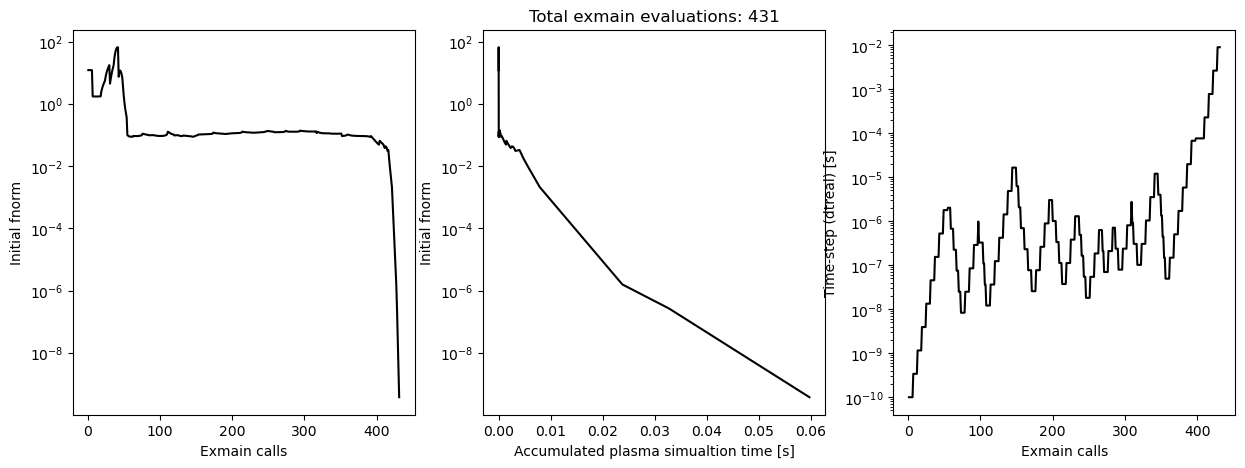

In [47]:
c.solver.convergenceanalysis('reconverged_v9_integrated_puff_last_ii2.hdf5');

# Inner plate

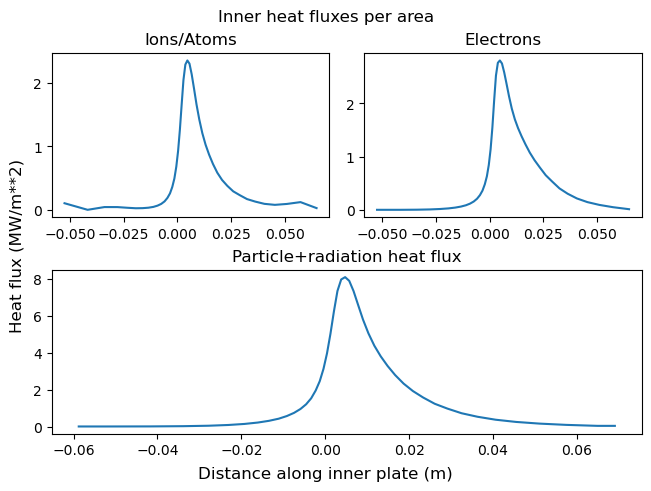

In [37]:
# %matplotlib widget
fig, axs = plt.subplot_mosaic(
    [['TopLeft', 'TopRight'],
     ['Bottom', 'Bottom']],
    layout='constrained',  # Automatically adjust layout
    width_ratios=[1, 1],   # Equal width for the top plots
)
fig.suptitle('Inner heat fluxes per area')
fig.supxlabel('Distance along inner plate (m)')
fig.supylabel('Heat flux (MW/m**2)')
# axs['TopRight'].set_xlabel("Distance along inner plate (m)")
#axs['TopRight'].set_ylabel("feex (W)")
axs['TopRight'].set_title("Electrons")
axs['TopRight'].plot(com.yylb[1:-1],-bbb.feex[0,1:-1]/com.sx[0,1:-1]*1e-6)

# axs['TopLeft'].set_xlabel("Distance along inner plate (m)")
# axs['TopLeft'].set_ylabel("Heat flux (MW/m**2)")
axs['TopLeft'].set_title("Ions/Atoms")
axs['TopLeft'].plot(com.yylb[1:-1],-bbb.feix[0,1:-1]/com.sx[0,1:-1]*1e-6) #polodal east field area

bbb.fqp=0
bbb.plateflux(); #internally calculated fluxes (postprocessing)
# axs['Bottom'].set_xlabel("Distance along inner plate (m)")
# axs['Bottom'].set_ylabel("Heat flux [MW/m**2]")
axs['Bottom'].set_title("Particle+radiation heat flux")
axs['Bottom'].plot(com.yylb,1.e-6*(bbb.sdtlb+bbb.sdrlb))
plt.show()

In [ ]:
# %matplotlib inline
plt.cla()
plt.xlabel("Distance along inner plate (m)")
plt.ylabel("feex")
plt.title("Ion density")
plt.plot(com.yylb[1:-1],bbb.ni[0,1:-1,0])
plt.show()
plt.xlabel("Distance along inner plate (m)")
plt.ylabel("feex")
plt.title("Ion temp")
plt.plot(com.yylb[1:-1],bbb.ti[0,1:-1]/bbb.ev)
plt.show()
plt.xlabel("Distance along inner plate (m)")
plt.ylabel("feex")
plt.title("Elc temp")
plt.plot(com.yylb[1:-1],bbb.te[0,1:-1]/bbb.ev)
plt.show()

# Midplane

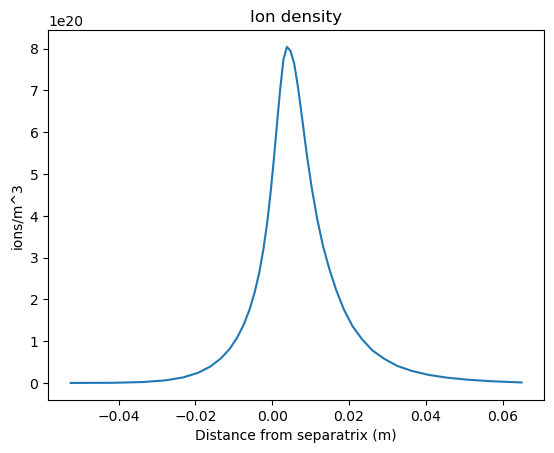

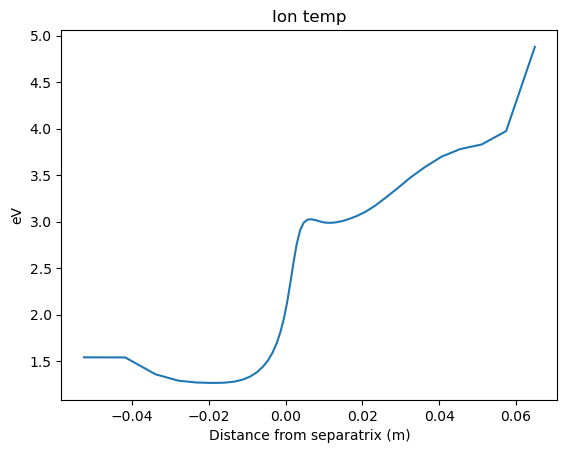

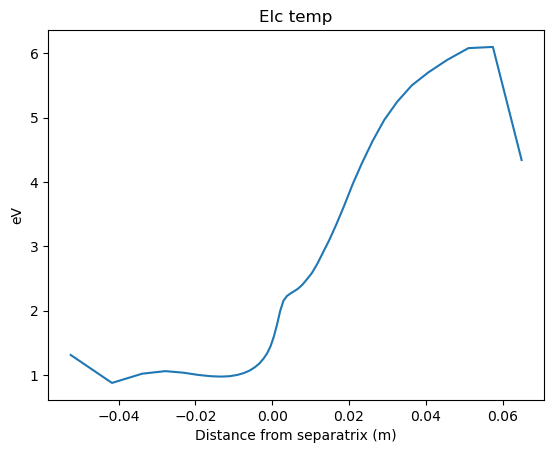

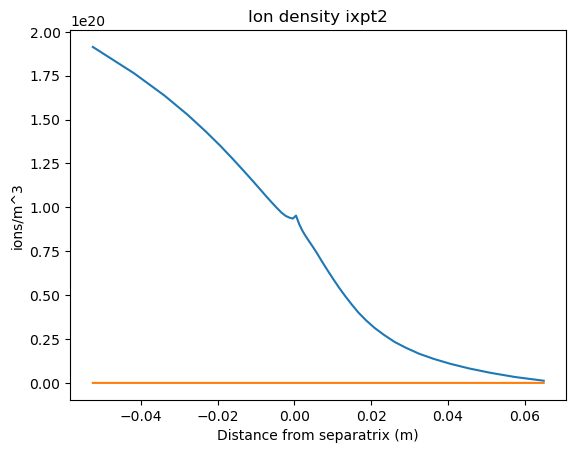

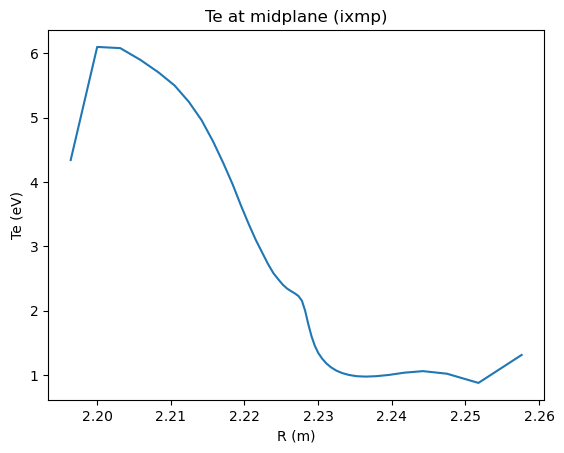

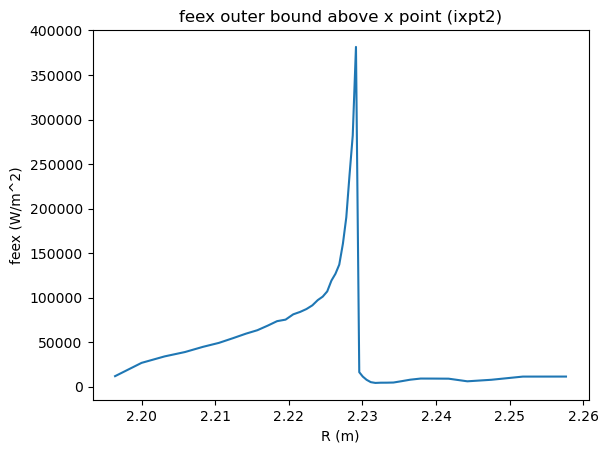

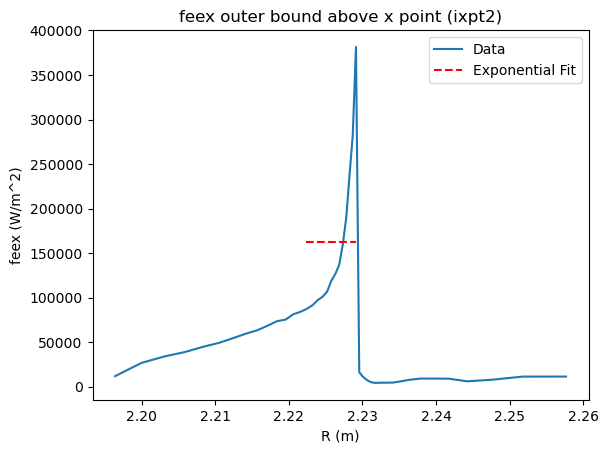

Optimized n: 12.001245771549137
Optimized k: 274309981.53708845


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("ions/m^3")
plt.title("Ion density")
plt.plot(com.yylb[1:-1],bbb.ni[bbb.ixmp,1:-1,0])
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("eV")
plt.title("Ion temp")
plt.plot(com.yylb[1:-1],bbb.ti[bbb.ixmp,1:-1]/bbb.ev)
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("eV")
plt.title("Elc temp")
plt.plot(com.yylb[1:-1],bbb.te[bbb.ixmp,1:-1]/bbb.ev)
plt.show()

'''#for heat flux wall mapping fix with Filippo's method
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("feix (W/m^2)")
plt.title("Ion temp * Bpol/Btot")
plt.plot(com.yylb[1:-1],bbb.ti[com.ixpt2[0],1:-1].T/bbb.ev*((com.bpol[com.ixpt2[0],1:-1,0]/com.b[com.ixpt2[0],1:-1,0])))
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("feex (W/m^2)")
plt.title("Elc temp * Bpol/Btot")
plt.plot(com.yylb[1:-1],bbb.te[com.ixpt2[0],1:-1].T/bbb.ev*((com.bpol[com.ixpt2[0],1:-1,0]/com.b[com.ixpt2[0],1:-1,0])))
plt.show()'''

#For length scale need real distance from separatrix at midplane

plt.xlabel("Distance from separatrix (m)")
plt.ylabel("ions/m^3")
plt.title("Ion density ixpt2")
plt.plot(com.yylb[1:-1],bbb.ni[com.ixpt2[0],1:-1])
plt.show()

'''plt.xlabel("R (m)")
plt.ylabel("Ti (eV)")
plt.title("Ti at midplane (ixmp)")
plt.plot(rad,bbb.ti[bbb.ixmp,1:-1]/bbb.ev)
plt.show()'''

rad = [arr[0] for arr in com.rm[bbb.ixmp, 1:-1]] #average index 2 and 4 for arr

plt.xlabel("R (m)")
plt.ylabel("Te (eV)")
plt.title("Te at midplane (ixmp)")
plt.plot(rad,bbb.te[bbb.ixmp,1:-1]/bbb.ev)
plt.show()
plt.xlabel("R (m)")
plt.ylabel("feex (W/m^2)")
plt.title("feex outer bound above x point (ixpt2)")
plt.plot(rad,bbb.feex[com.ixpt2[0],1:-1])
plt.show()

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def exponential_func(x, n, k):
    return np.exp(n - x / k)

x_data = rad
y_data = bbb.feex[com.ixpt2[0], 1:-1]

x_data_outward = x_data[17:30]
y_data_outward = y_data[17:30]

try:
    popt, pcov = curve_fit(exponential_func, x_data_outward, y_data_outward, p0=[np.log(y_data_outward[0]), 1], maxfev=10000)
    
    plt.xlabel("R (m)")
    plt.ylabel("feex (W/m^2)")
    plt.title("feex outer bound above x point (ixpt2)")
    plt.plot(x_data, y_data, label="Data")
    x_fit = np.linspace(min(x_data_outward), max(x_data_outward), 100)
    y_fit = exponential_func(x_fit, *popt)
    plt.plot(x_fit, y_fit, 'r--', label="Exponential Fit")
    plt.legend()
    plt.show()

except RuntimeError as e:
    print("Curve fitting did not converge:", e)

n_opt, k_opt = popt
print(f"Optimized n: {n_opt}")
print(f"Optimized k: {k_opt*1000}") 

bbb.afracs


# Outer plate

<Figure size 640x480 with 0 Axes>

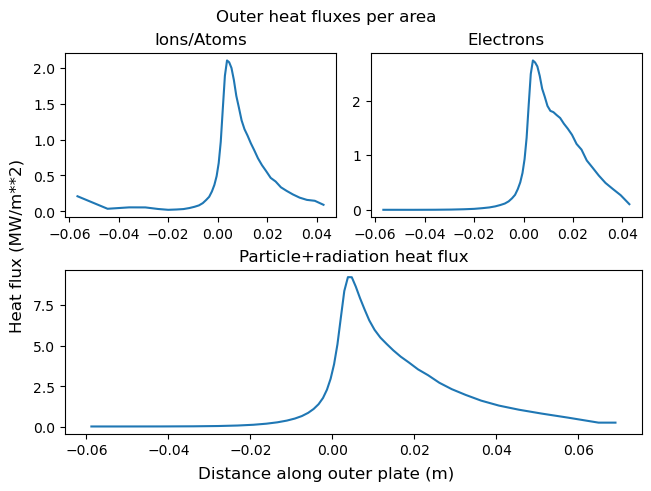

array([9.23913732])

In [38]:
# total convective and conductive heat flux
# 2nd char: e for energy n for particle
plt.figure()
fig, axs = plt.subplot_mosaic(
    [['TopLeft', 'TopRight'],
     ['Bottom', 'Bottom']],
    layout='constrained',  # Automatically adjust layout
    width_ratios=[1, 1],   # Equal width for the top plots
)
fig.suptitle('Outer heat fluxes per area')
fig.supxlabel('Distance along outer plate (m)')
fig.supylabel('Heat flux (MW/m**2)')
# axs['TopRight'].set_xlabel("Distance along inner plate (m)")
#axs['TopRight'].set_ylabel("feex (W)")
axs['TopRight'].set_title("Electrons")
axs['TopRight'].plot(com.yyrb[1:-1],bbb.feex[com.nx,1:-1]/com.sx[0,1:-1]*1e-6)

# axs['TopLeft'].set_xlabel("Distance along inner plate (m)")
# axs['TopLeft'].set_ylabel("Heat flux (MW/m**2)")
axs['TopLeft'].set_title("Ions/Atoms")
axs['TopLeft'].plot(com.yyrb[1:-1],bbb.feix[com.nx,1:-1]/com.sx[0,1:-1]*1e-6) #polodal east field area

bbb.fqp=0
bbb.plateflux(); #internally calculated fluxes (postprocessing)
# axs['Bottom'].set_xlabel("Distance along inner plate (m)")
# axs['Bottom'].set_ylabel("Heat flux [MW/m**2]")
axs['Bottom'].set_title("Particle+radiation heat flux")
axs['Bottom'].plot(com.yylb,1.e-6*(bbb.sdtrb+bbb.sdrrb))
plt.show()
max(1.e-6*(bbb.sdtrb+bbb.sdrrb))

# 2D Plots

<Figure size 640x480 with 0 Axes>

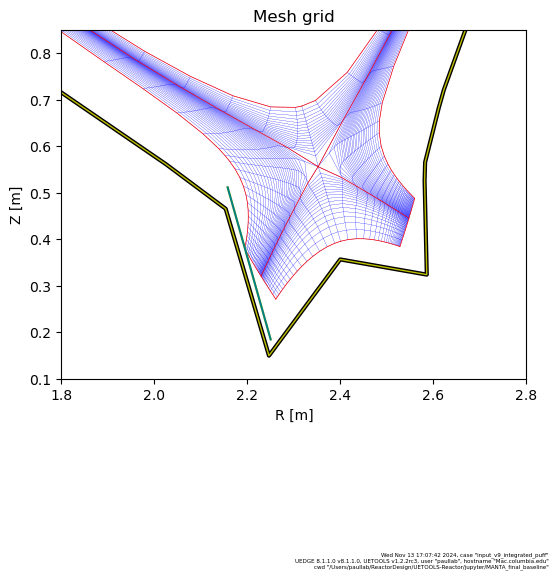

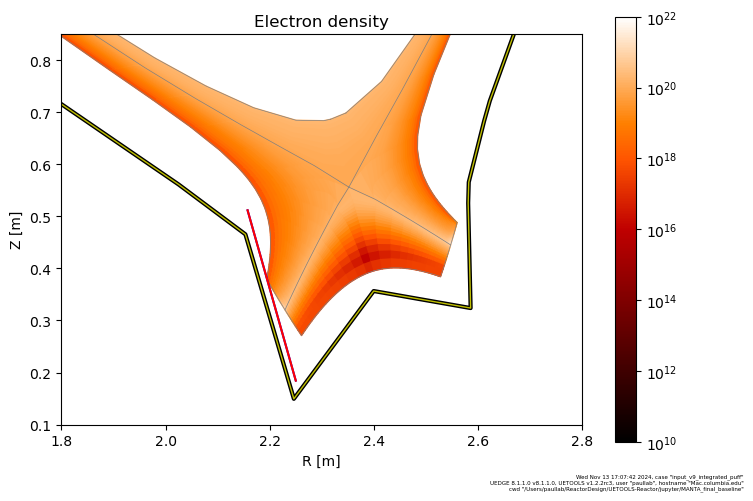

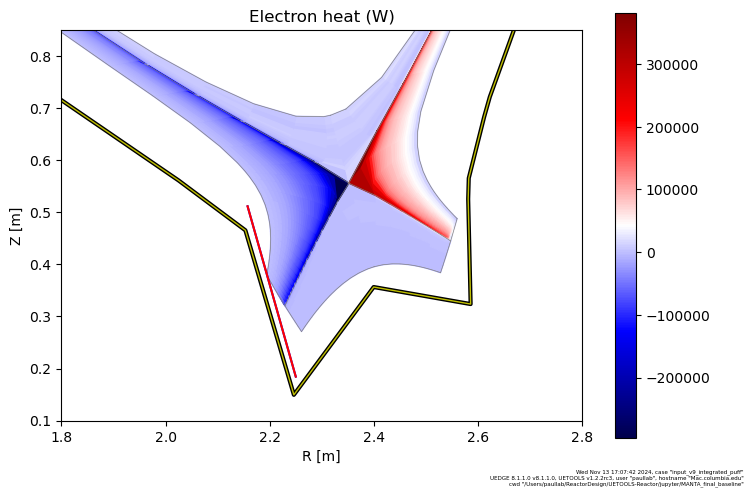

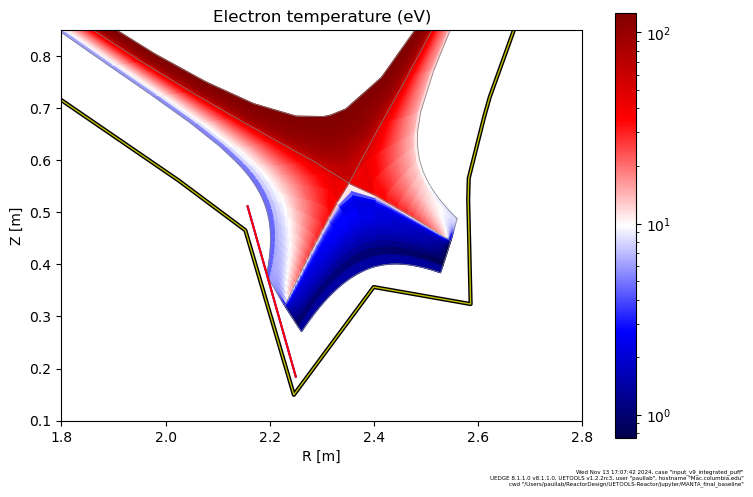

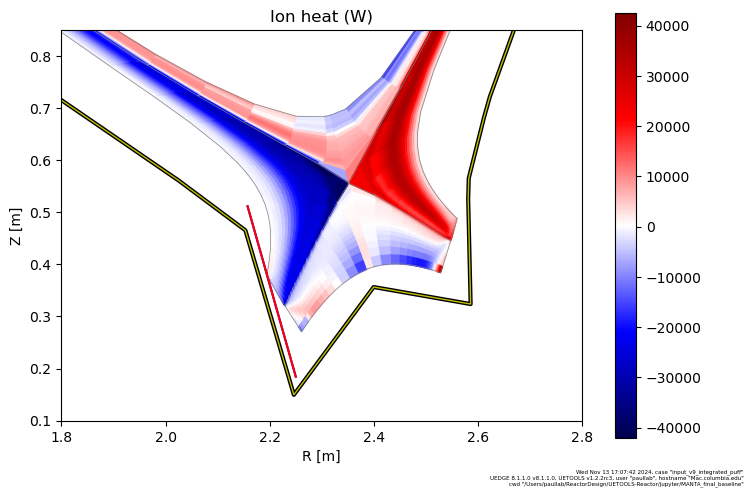

In [5]:
plt.figure()

c.plot.grid(linewidth=0.1, #grid plot
   vessel=True, 
   plates=True, 
   platecolor=['gold','teal'], 
   lcfs=True, 
   xlim=(1.8, 2.8), 
   ylim=(0.1,0.85),
   lcfscolor='r', 
   linecolor='b',
   title='Mesh grid'
  );

c.plot.mesh(
    bbb.ne, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85),
    figsize=(7,5), 
    zrange=(1e10,1e22), 
    cmap='gist_heat',
    title='Electron density'
);


c.plot.mesh(
    bbb.feex, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(-8e5,8e5),
    cmap='seismic',
    title='Electron heat (W)'
);
c.plot.mesh(
    bbb.te/bbb.ev, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(-5e5,5e5),
    cmap='seismic',
    title='Electron temperature (eV)'
);
c.plot.mesh(
    bbb.feix, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85),
    figsize=(7,5), 
    # zrange=(-8e5,8e5),
    cmap='seismic',
    title='Ion heat (W)'
);
plt.show()

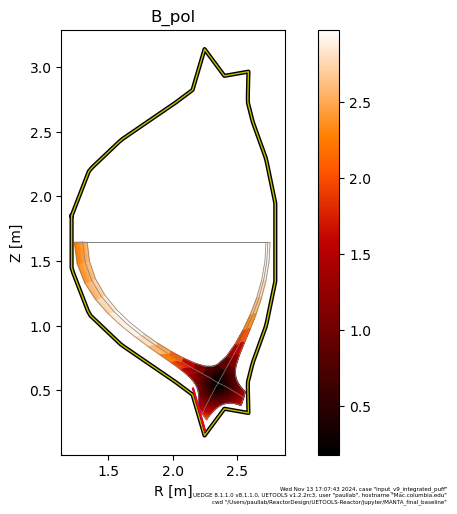

In [6]:
bpol = com.bpol[:,:,0]
c.plot.mesh(
    bpol, 
    # log=True, 
    figsize=(7,5),
    # ylim=(0,1.5) ,
    # zrange=(.42,.48), 
    cmap='gist_heat',
    title='B_pol'
);


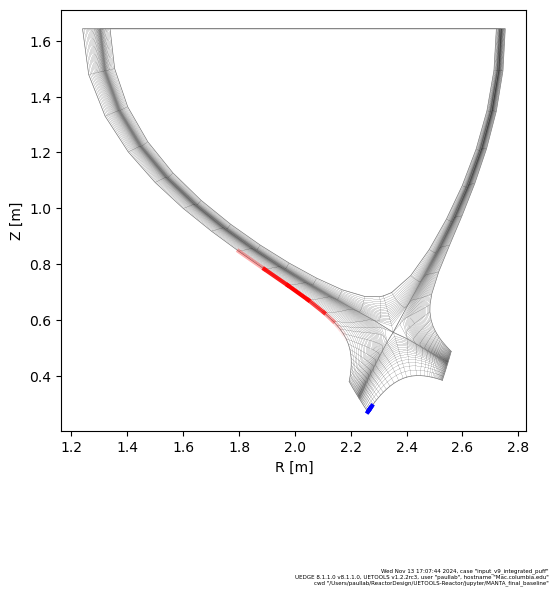

In [7]:
from plot_sinksource import plot_sinksource
plot_sinksource(c)

# Power Calculations

In [9]:
from scipy.integrate import simpson
bbb.fqp=0
bbb.plateflux();

psep = simpson( (bbb.feiy+bbb.feey)[com.ixpt1[0]+1:com.ixpt2[0],com.iysptrx]) / 1e6
pcore = simpson( (bbb.feiy+bbb.feey)[com.ixpt1[0]+1:com.ixpt2[0],0]) / 1e6

print(f' Power from core boundary (surface closest to magnetic axis) = {pcore:.3f} MW  \n \
Power at Separatrix = {psep:.3f} MW  \n \
Power radiated in core region = {(pcore-psep):.3f} MW ')

 Power from core boundary (surface closest to magnetic axis) = 10.010 MW  
 Power at Separatrix = 7.726 MW  
 Power radiated in core region = 2.284 MW 


In [1]:
c.dashboard()

NameError: name 'c' is not defined

In [10]:
bbb.te[33]/bbb.ev

array([128.22116794, 126.61091017, 123.06760783, 119.64173276,
       116.26310679, 112.88755886, 109.4503954 , 105.94603992,
       102.3690836 ,  98.6831674 ,  94.88874583,  90.96552548,
        86.90371052,  82.72686655,  78.42241916,  73.99439052,
        69.4875118 ,  64.94217688,  60.5377997 ,  56.61882337,
        53.21479662,  50.32384085,  47.80136581,  45.5148853 ,
        43.45876978,  41.57824669,  39.83037978,  38.19493185,
        36.64880903,  35.18627059,  33.79135298,  32.42583889,
        31.083659  ,  29.78716147,  28.51226705,  27.26334363,
        26.02814615,  24.81012313,  23.62207354,  22.46756541,
        21.34558064,  20.25433048,  19.140092  ,  17.7032547 ,
        13.90539944,  11.9260916 ])

In [80]:
c.search.var("feiy")
c.search.var("sdrrb")


Package:    bbb
Group:      Comflo
Attributes: Comflo 
Dimension:  (0:nx+1,0:ny+1)
            (66, 46)
Type:       double
Address:    5780300288
Pyaddress:  4857427696
Unit:       J/s
Comment:
radial ion thermal current, north face
Package:    bbb
Group:      Postproc
Attributes: Postproc 
Dimension:  (0:ny+1,1:nxpt)
            (46, 1)
Type:       double
Address:    5377164624
Pyaddress:  4857418768
Unit:       W/m**2
Comment:
tot rad flux to right div


In [6]:
(c.tools.hdf5search("gridue_v9.hdf5", "bpol")[1:-1,1:-1]/c.tools.hdf5search("gridue_v7.hdf5", "bpol")[1:-1,1:-1]).min()

np.float64(0.34848328109775634)

In [50]:
print(grd.rplate1,grd.rplate2,grd.zplate1,grd.zplate1)

[2.1575 2.25  ] [2.1575 2.25  ] [0.51150784 0.18450784] [0.51150784 0.18450784]
